# Autoencoder

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras import Model

## Define Autoencoder class

In [2]:
class Encoder(Layer):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = Dense(units = hidden_dim, activation='relu')
        self.output_layer = Dense(units = hidden_dim, activation='relu')
        
    def call(self, features):
        activation = self.hidden_layer(features)
        return self.output_layer(activation)


In [3]:
class Decoder(Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = Dense(units = hidden_dim, activation='relu')
        self.output_layer = Dense(units = original_dim, activation='relu')
        
    def call(self, features):
        activation = self.hidden_layer(features)
        return self.output_layer(activation)


In [4]:
class Autoencoder(Model):
    def __init__(self, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim)
        self.decoder = Decoder(hidden_dim, original_dim)
        
    def call(self, features):
        code = self.encoder(features)
        return self.decoder(code)

## Load data

In [5]:
(training_features, _), (_, _) = keras.datasets.mnist.load_data()
training_features = training_features / np.max(training_features)
training_features = training_features.reshape(
    training_features.shape[0],
    training_features.shape[1] * training_features.shape[2]).astype(np.float32)


## Train and evaluate autoencoder

In [6]:
autoencoder = Autoencoder(hidden_dim=64, original_dim = training_features.shape[1])
autoencoder.compile(optimizer='rmsprop', loss='mse')

In [7]:
%%time

autoencoder.fit(training_features, training_features, epochs=10, batch_size=32)

Epoch 1/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0276
Epoch 2/10
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0198
Epoch 3/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0184
Epoch 4/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0175
Epoch 5/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.0169
Epoch 6/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0165
Epoch 7/10
60000/60000 [==============================] - 4s 75us/sample - loss: 0.0162
Epoch 8/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0160
Epoch 9/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0158
Epoch 10/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0157
Wall time: 44.8 s


In [8]:
import matplotlib
import matplotlib.pyplot as plt

def display(originals, autoencoder):
    rows = 28
    cols = 28
    transformed = autoencoder.predict(originals)
    
    fig, axs = plt.subplots(2, len(originals))
    fig.set_size_inches(40, 10)
    
    #fig = plt.figure(figsize=(28, 28))
    for i, number in enumerate(originals):
        axs[0,i].imshow(number.reshape(rows, cols), cmap = matplotlib.cm.binary, interpolation='nearest')
    
    for i, number in enumerate(transformed):
        axs[1,i].imshow(number.reshape(rows, cols), cmap = matplotlib.cm.binary, interpolation='nearest')

    fig.tight_layout()
    plt.show()

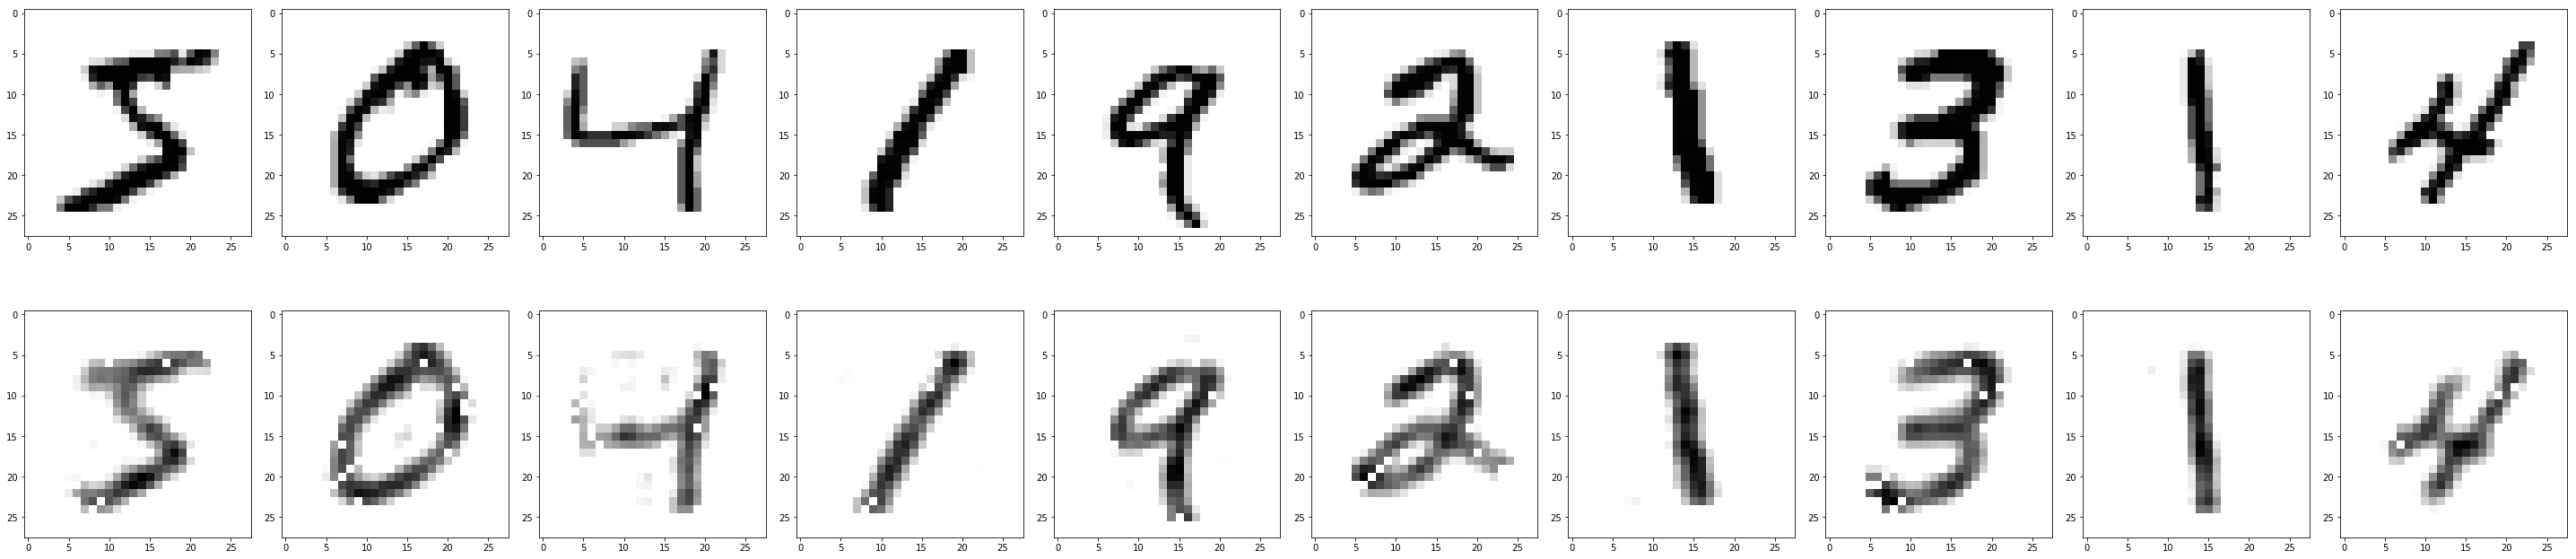

In [9]:
display(training_features[:10], autoencoder)